In [1]:
import os
import pandas as pd
import numpy as np
import plotly as py
import gensim
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import warnings
import jdatetime
from textblob import TextBlob
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import unicodedata
import nltk
# NL TK stop words
from nltk.corpus import stopwords
# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# Plotting tooLs
import pyLDAvis.gensim # don't skip this
import tqdm
import itertools
import pickle
import collections
import networkx as nx
from tqdm import tqdm
from hazm import *
from bidi.algorithm import get_display
import arabic_reshaper
from wordcloud_fa import WordCloudFa
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
wc = WordCloudFa(width = 1000, height = 500, background_color="white", persian_normalize=True)
stemmer = Stemmer()
%matplotlib inline
py.offline.init_notebook_mode(connected=True) #do not miss this line
warnings.filterwarnings("ignore")
N = 16

In [2]:
def compute_coherence_values (dictionary, corpus, texts, limit, start=2, step=1):
    """
    compute c_v coherence for various number of topics
    Parameters :
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range (start, limit, step)) :
        model = gensim.models.ldamodel. LdaModel(corpus=corpus, num_topics=num_topics,random_state=100,
        chunksize=200 ,passes=10,per_word_topics=True ,id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v' )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [3]:
stopwords=[]
dir = 'persian-stopwords/'
files =['chars', 'nonverbal', 'persian', 'short', 'verbal']
for fs in files:
    path = dir + fs
    with open(path, encoding='utf-8') as f:
        content = f.readlines()
    stopwords.extend ([x.strip() for x in content])

In [4]:
total_lines=[]
file_name = ''
dir = 'data2/interviews/'
for i in range (1, N):
    path = dir + 'interview' + str(i).zfill(2) +'.txt'
    with open(path) as file:
        lines = file.readlines()
        lines = [line.rstrip().replace('.', '') for line in lines]
    total_lines = total_lines + lines

In [5]:
total_sentences=[]
for i in tqdm(range(len(total_lines))):
    lwd = re.sub(r'\d+', '', total_lines [i])
    lwd = lwd.replace('...','')
    lwd = lwd.replace('(:)','')
    sentence = sent_tokenize(lwd) 
    total_sentences = total_sentences + sentence

100%|██████████| 391/391 [00:00<00:00, 10000.57it/s]


In [6]:
raw_text=[]
for i in tqdm(range(len(total_sentences))):
    tokens = word_tokenize(total_sentences [i]) 
    token_filtered = [t for t in tokens if len (t) >=3]
    words = [w for w in token_filtered if w.lower() not in stopwords]
    sentence =(' ').join(words)
    raw_text.append(sentence)

100%|██████████| 367/367 [00:00<00:00, 422.21it/s]


In [7]:
def sent_to_words (sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str (sentence), deacc=True)) # deacc=True removes punctuati ons
data_words = list (sent_to_words(raw_text))

In [8]:
data_lemmatized = list (sent_to_words(raw_text))

In [9]:
# Create Dictionary
id2word = corpora.Dictionary (data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [10]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=1 )

100%|██████████| 18/18 [01:26<00:00,  4.83s/it]


In [12]:
with open('coherence_values.pickle', 'wb') as fp:
    pickle.dump(coherence_values, fp)

In [13]:
with open ('coherence_values.pickle', 'rb') as fp:
    coherence_values_p = pickle.load(fp)

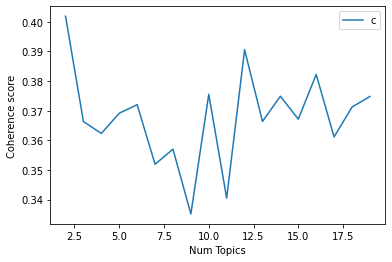

In [14]:
# Show graph
limit=20; start=2; step=1 ;
x = range (start, limit, step)
plt.plot(x, coherence_values_p)
plt.xlabel ( "Num Topics" )
plt.ylabel( "Coherence score" )
plt.legend(( "coherence_values" ), loc='best' )
plt.savefig('coherence_values.png', dpi=300)
plt.show()

In [15]:
max_cv = 0
max_topics = 2
limit=20; start=2; step=1 ;
x = range (start, limit, step)
for m, cv in zip(x, coherence_values_p):
    if cv > max_cv:
        max_cv = cv
        max_topics = m
    print ('Num Topics= ', m, 'has Coherence Value of', round (cv, 4))

Num Topics=  2 has Coherence Value of 0.4019
Num Topics=  3 has Coherence Value of 0.3663
Num Topics=  4 has Coherence Value of 0.3623
Num Topics=  5 has Coherence Value of 0.3691
Num Topics=  6 has Coherence Value of 0.372
Num Topics=  7 has Coherence Value of 0.3519
Num Topics=  8 has Coherence Value of 0.357
Num Topics=  9 has Coherence Value of 0.3352
Num Topics=  10 has Coherence Value of 0.3755
Num Topics=  11 has Coherence Value of 0.3405
Num Topics=  12 has Coherence Value of 0.3906
Num Topics=  13 has Coherence Value of 0.3664
Num Topics=  14 has Coherence Value of 0.3749
Num Topics=  15 has Coherence Value of 0.3671
Num Topics=  16 has Coherence Value of 0.3822
Num Topics=  17 has Coherence Value of 0.3612
Num Topics=  18 has Coherence Value of 0.3712
Num Topics=  19 has Coherence Value of 0.3748


In [27]:
n_features = 1000
n_components = 12
n_top_words = 30
b0 = 100
b1 = b0 / n_components
b2 = b1 / n_top_words

In [28]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=n_components,
                                                    random_state=100,
                                                    chunksize=200 ,
                                                    passes=10,
                                                    alpha=0.01,
                                                    eta=0.91 ,
                                                    per_word_topics=True)

In [29]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v' )
coherence_lda = coherence_model_lda.get_coherence()
print ('\ncoherence score:' , coherence_lda)


coherence score: 0.35676810314261903


  0%|          | 0/12 [00:00<?, ?it/s]

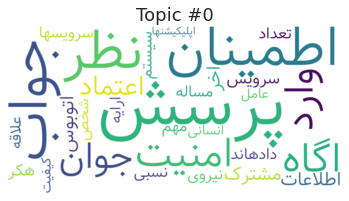

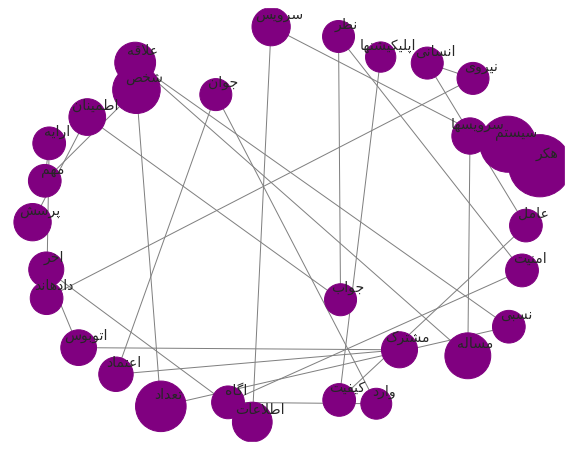

  8%|▊         | 1/12 [00:04<00:48,  4.43s/it]

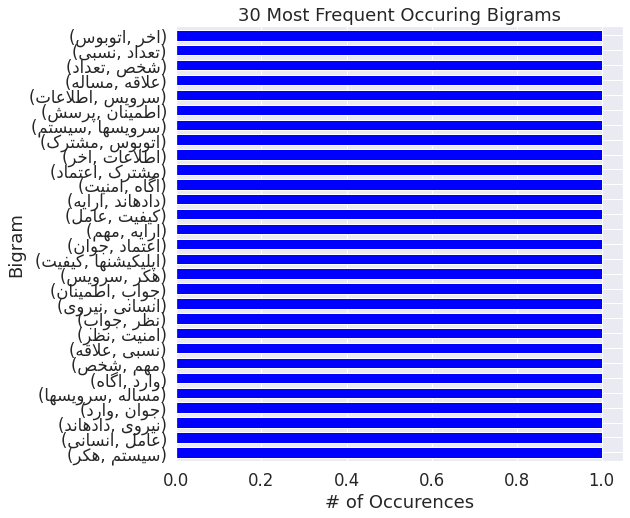

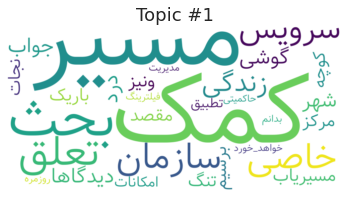

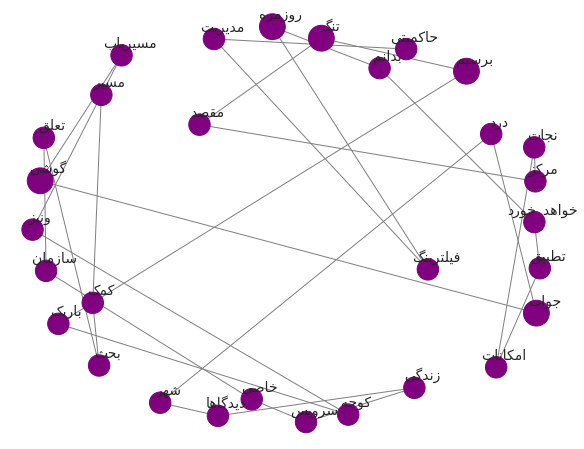

 17%|█▋        | 2/12 [00:09<00:46,  4.65s/it]

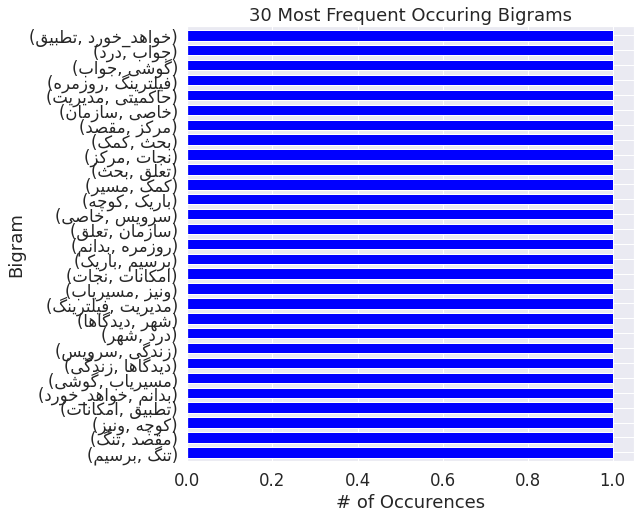

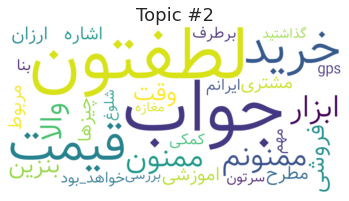

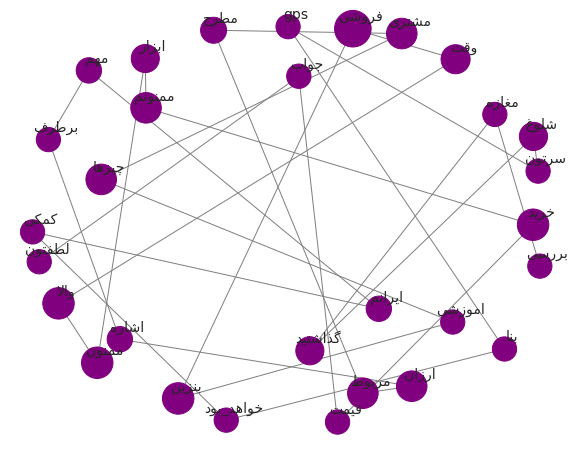

 25%|██▌       | 3/12 [00:14<00:41,  4.64s/it]

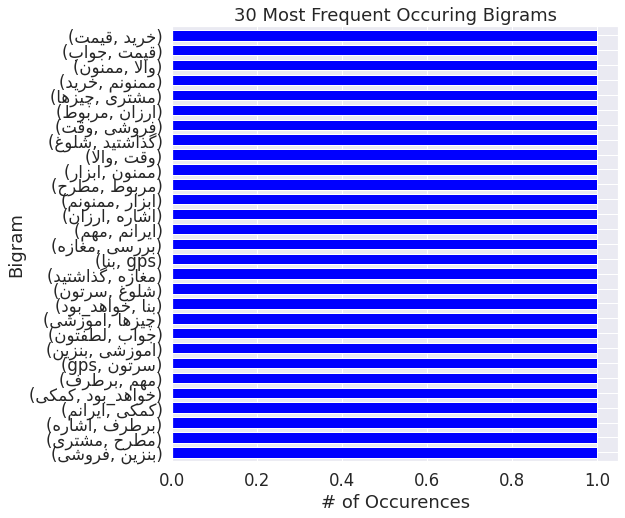

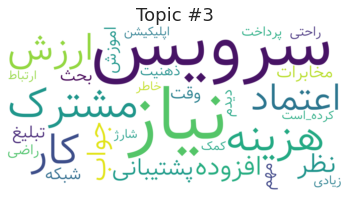

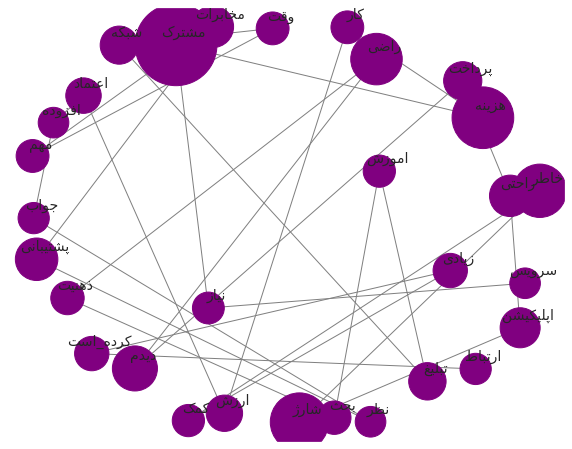

 33%|███▎      | 4/12 [00:18<00:36,  4.62s/it]

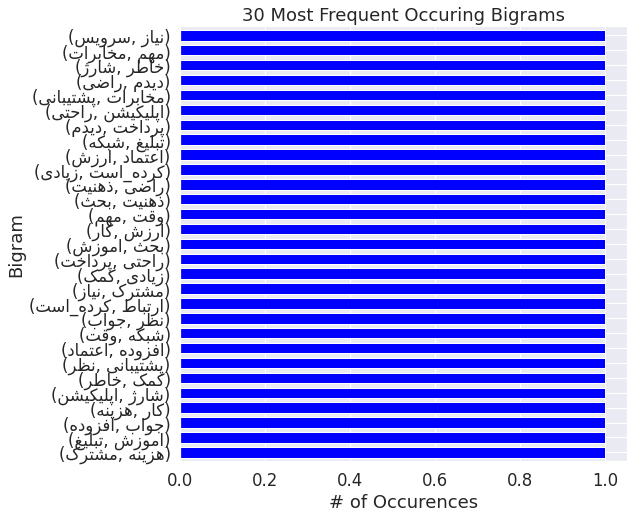

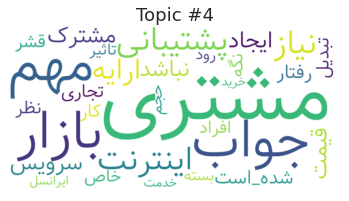

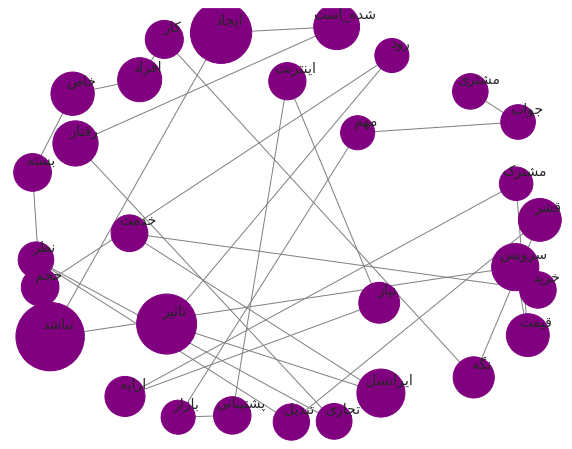

 42%|████▏     | 5/12 [00:23<00:32,  4.63s/it]

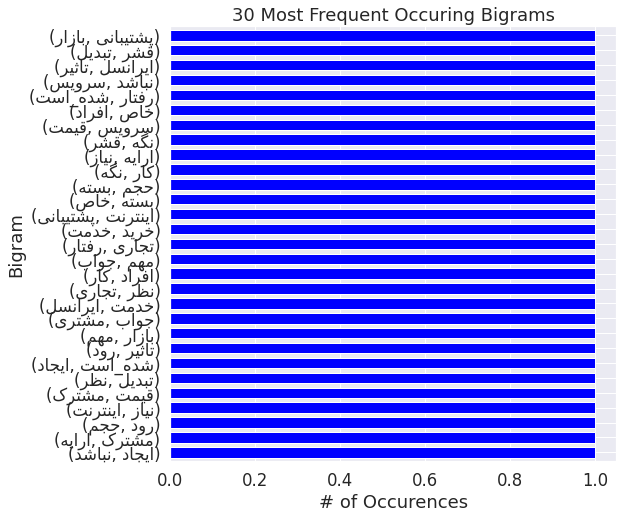

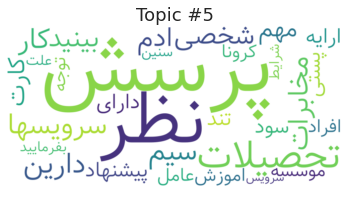

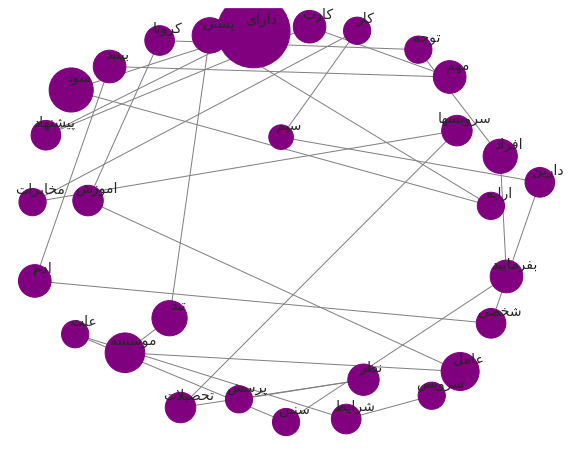

 50%|█████     | 6/12 [00:28<00:27,  4.67s/it]

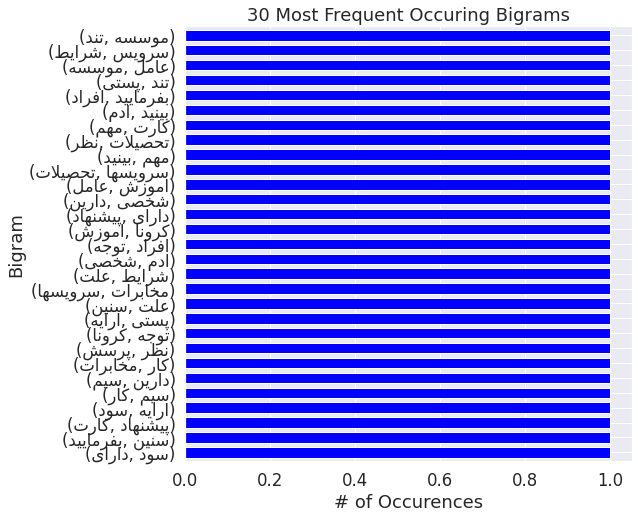

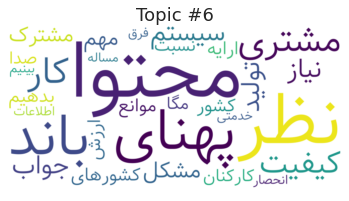

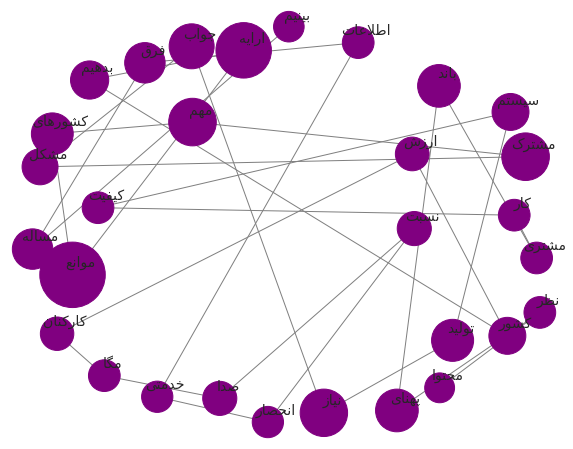

 58%|█████▊    | 7/12 [00:33<00:23,  4.76s/it]

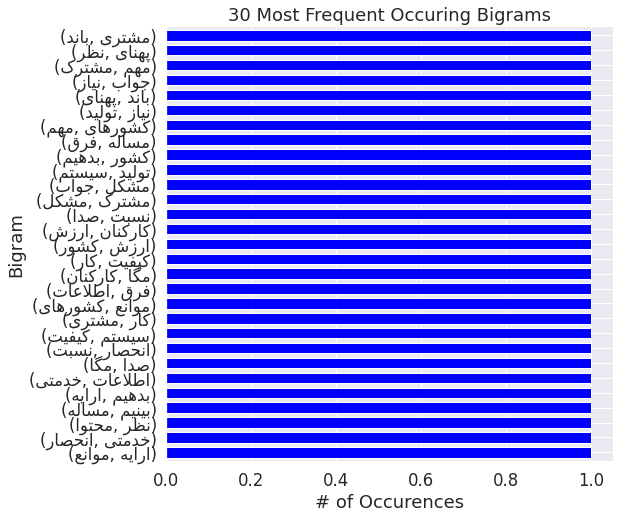

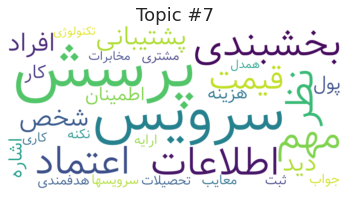

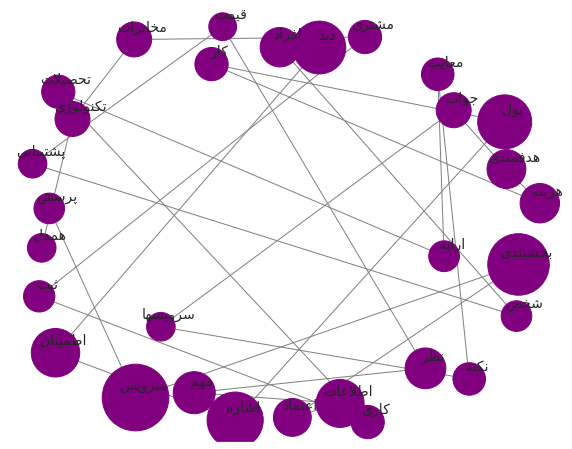

 67%|██████▋   | 8/12 [00:38<00:19,  4.79s/it]

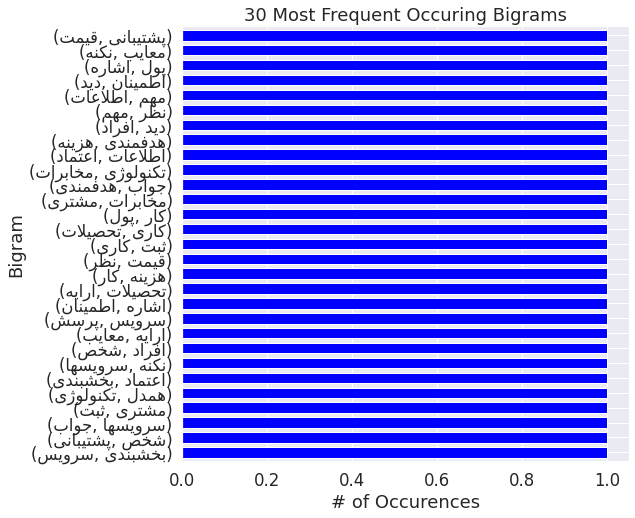

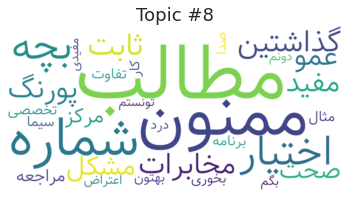

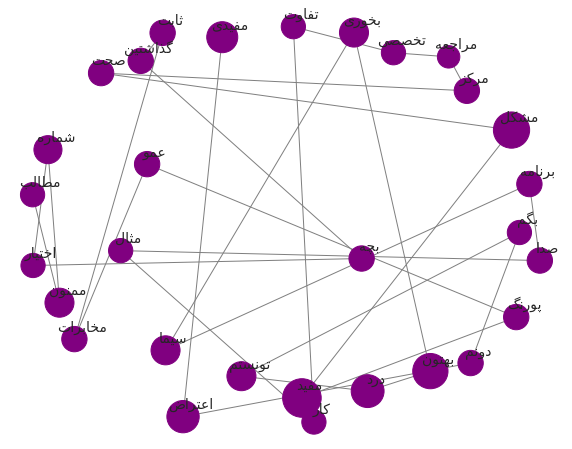

 75%|███████▌  | 9/12 [00:42<00:14,  4.73s/it]

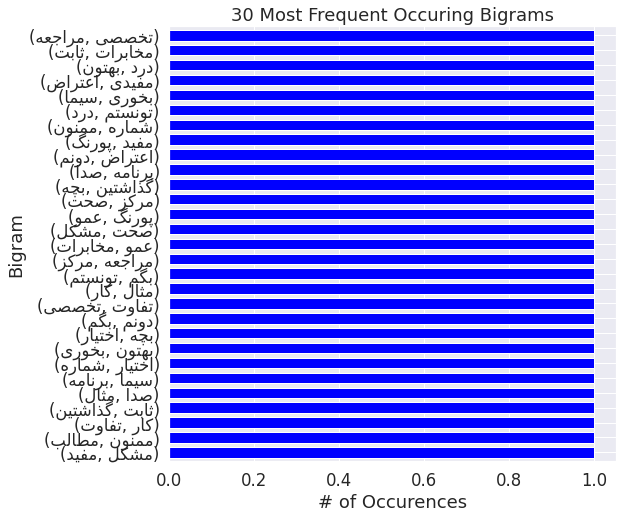

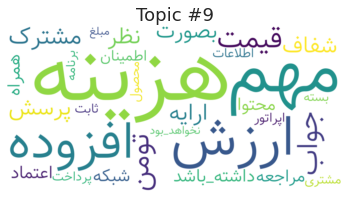

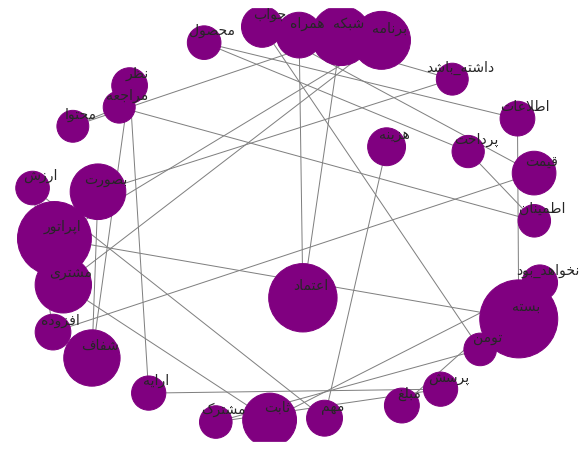

 83%|████████▎ | 10/12 [00:47<00:09,  4.76s/it]

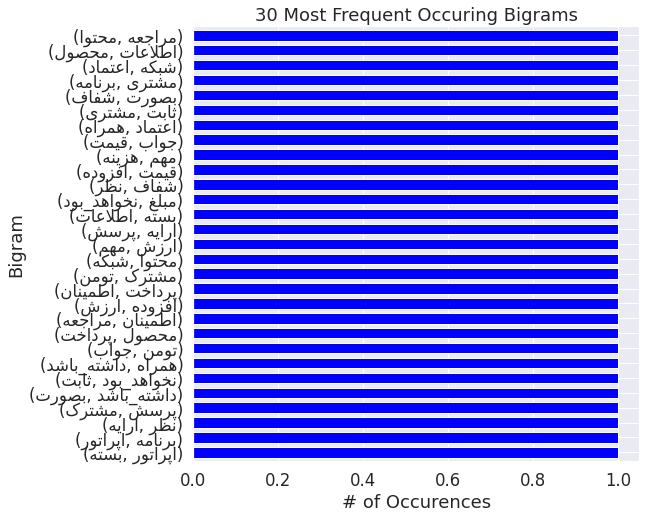

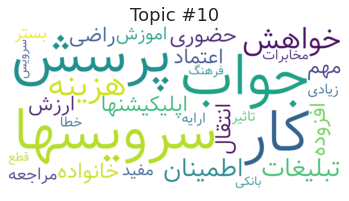

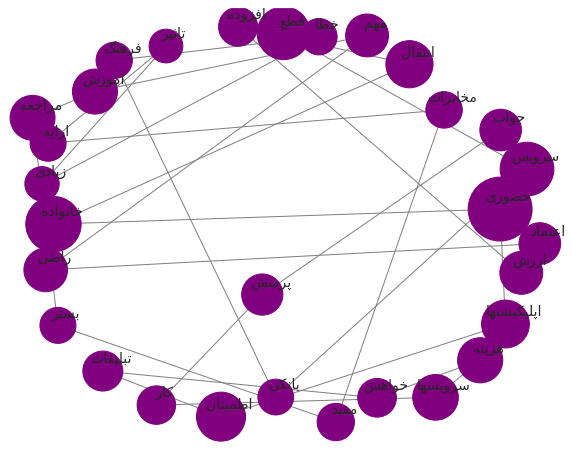

 92%|█████████▏| 11/12 [00:52<00:04,  4.77s/it]

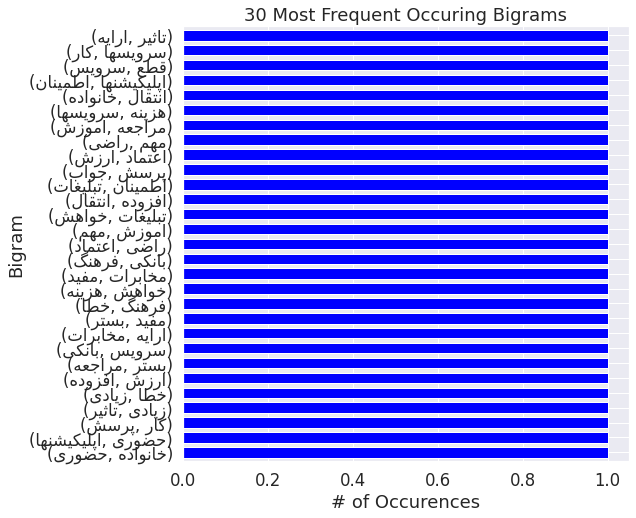

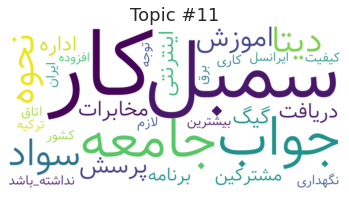

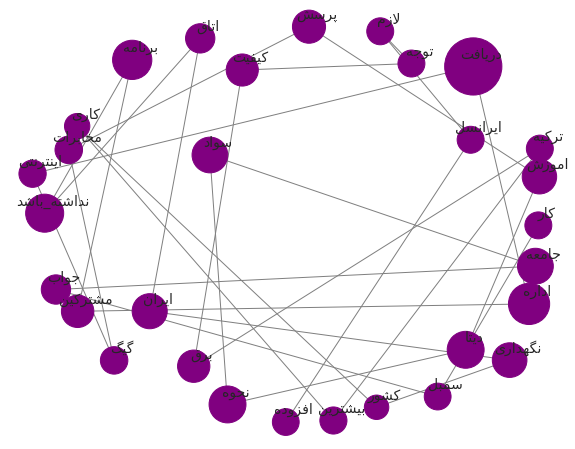

100%|██████████| 12/12 [00:57<00:00,  4.76s/it]


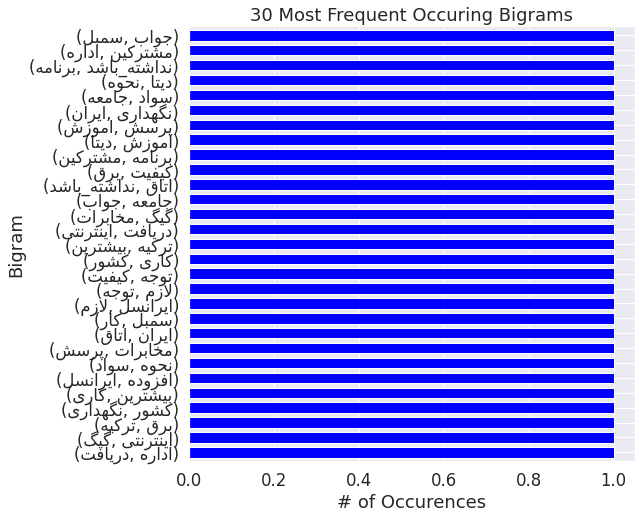

In [30]:
tt = []
plt.rcParams.update({'font.size': 16})

for index in tqdm(range (lda_model.num_topics)):
    topic = lda_model.show_topic(index, n_top_words)
    topic_words =list(zip(*topic))
    topic_words_list = list(topic_words[0])
    topic_words_weight_list = list(topic_words[1])   
    tl = []
    rs=[]
    i =0 
    for word in topic_words_list:
        tl.append((get_display(arabic_reshaper.reshape(word)), b2, [])) 
        rs.append(get_display(arabic_reshaper.reshape(word)))
        i+=1   
    tt.append((index,b1, tl)) 
    topic_words_string=' '.join(topic_words_list)
    wordcloud =wc.generate(topic_words_string)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic #" + str(index))
    plt.savefig('wc' + str(index) + '.png', dpi=300)
    plt.show()
    bigrams_series = (pd.Series(nltk.ngrams(rs,2)).value_counts())
    bigrams_df = bigrams_series.to_frame(name='count')
    bigrams_df.index.names = ['bigram']
    sns.set(font_scale=1.5)
    d = bigrams_df.T.to_dict('records')
    # Create network plot 
    G = nx.Graph()
    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v))  
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_facecolor('white')
    pos = nx.spring_layout(G, k=2)
    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=16,
                     width=1,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     node_size=[v*500000 for v in topic_words_weight_list],
                     ax=ax)
    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+0.03, value[1]+.04
        ax.text(x, y,
                s = key,
                horizontalalignment='center', fontsize=14)  
    plt.savefig('bg' + str(index) + '.png', dpi=300)         
    plt.show()
    bigrams_series.sort_values().plot.barh(color='blue', width = .7, figsize = (8,8))
    plt.title(str (n_top_words) + ' Most Frequent Occuring Bigrams')
    plt.ylabel('Bigram')
    plt.xlabel('# of Occurences')
    plt.savefig('bgf' + str(index) + '.png', dpi=300)  
data = [(get_display(arabic_reshaper.reshape('برندینگ زعفران')), b0, tt)]     

In [31]:
def plot_top_words(model, n_top_words, title):
    fig, axes = plt.subplots(1, n_components, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for index in tqdm(range (model.num_topics)):
        topic = model.show_topic(index, n_top_words)
        topic_words =list(zip(*topic))
        topic_words_list = list(topic_words[0])
        topic_words_weight_list = list(topic_words[1])
        ax = axes[index]
        rs=[]
        for word in topic_words_list:
            rs.append(get_display(arabic_reshaper.reshape(word)))
        ax.barh(rs, topic_words_weight_list, height=0.7)
        ax.set_title(f'Topic {index +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40) 
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig('topics-lda.png', dpi=300)
    plt.show()

100%|██████████| 12/12 [00:02<00:00,  5.61it/s]


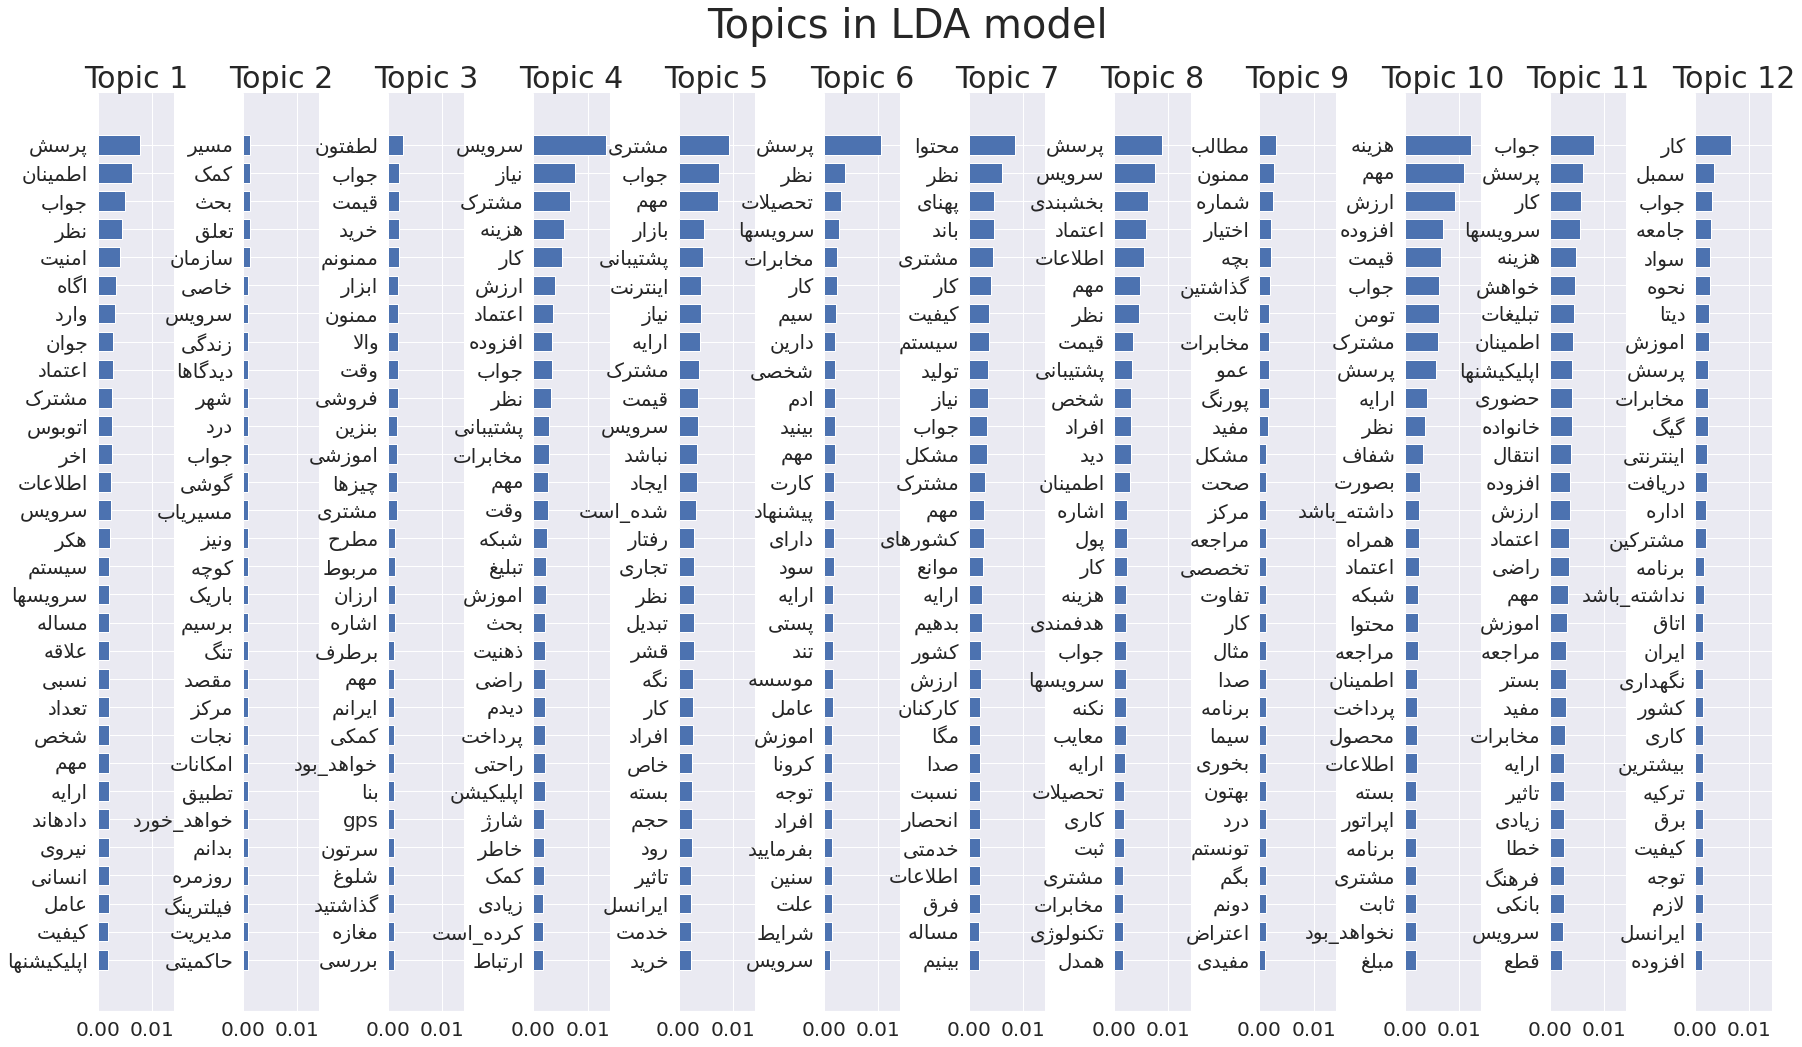

In [32]:
plot_top_words(lda_model, n_top_words, 'Topics in LDA model')

In [33]:
plt.rcParams.update({'font.size': 12})
def sunburst(nodes, total=np.pi * 2, offset=0, level=0, ax=None):
    f = plt.figure(figsize=(20,20))
    ax = ax or f.add_subplot(111, projection='polar')

    if level == 0 and len(nodes) == 1:
        label, value, subnodes = nodes[0]
        ax.bar([0], [0.5], [np.pi * 2])
        ax.text(0, 0, label, ha='center', va='center')
        sunburst(subnodes, total=value, level=level + 1, ax=ax)
    elif nodes:
        d = np.pi * 2 / total
        labels = []
        widths = []
        local_offset = offset
        for label, value, subnodes in nodes:
            labels.append(label)
            widths.append(value * d)
            sunburst(subnodes, total=total, offset=local_offset,
                     level=level + 1, ax=ax)
            local_offset += value
        values = np.cumsum([offset * d] + widths[:-1])
        heights = [1] * len(nodes)
        bottoms = np.zeros(len(nodes)) + level - 0.5
        rects = ax.bar(values, heights, widths, bottoms, linewidth=1,
                       edgecolor='white', align='edge')
        for rect, label in zip(rects, labels):
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2
            rotation = (90 + (360 - np.degrees(x) % 180)) % 360
            ax.text(x, y, label, rotation=rotation, ha='center', va='center') 

    if level == 0:
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.set_axis_off()
    return f

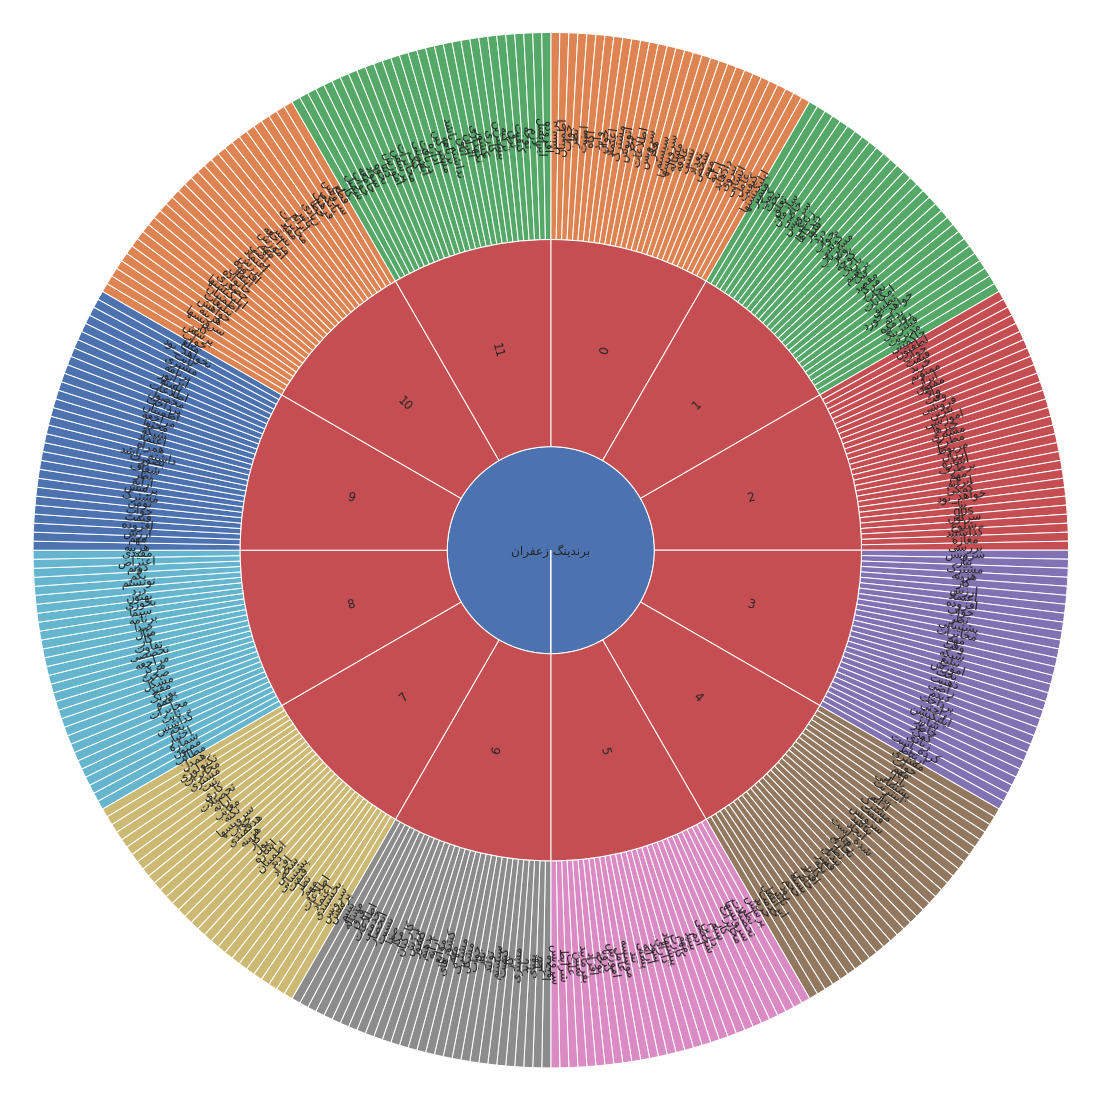

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [34]:
fig = sunburst(data)

In [35]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.009849  0.015575       1        1  15.966119
10    -0.034455  0.008489       2        1  14.958638
4      0.028479  0.022710       3        1  13.906131
9     -0.001754  0.025218       4        1  12.059531
6      0.021264 -0.009345       5        1  10.751161
0     -0.002567 -0.013864       6        1   9.484747
7     -0.001005  0.001274       7        1   8.675638
11    -0.001546 -0.011228       8        1   5.046475
5     -0.002720 -0.009932       9        1   3.862435
8      0.000024 -0.011313      10        1   2.398188
2      0.002085 -0.009613      11        1   1.865459
1      0.002045 -0.007972      12        1   1.025476, topic_info=      Term       Freq      Total Category  logprob  loglift
12    پرسش  24.000000  24.000000  Default  30.0000  30.0000
83   هزینه  21.000000  21.000000  Default  29.0000  29.0000
10   سرویس  25.000000  25.000000  Default  28.0000  28.0000
55   محتوا  10.000000  10.000000  Default  27.0000  27.0000
108  مشتری  15.000000  15.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
102    شهر   0.055964   3.591756  Topic12  -6.9940   0.4183
508    درد   0.055963   4.160553  Topic12  -6.9940   0.2713
17    جواب   0.055963  28.928249  Topic12  -6.9940  -1.6679
440   گوشی   0.055961   4.272249  Topic12  -6.9941   0.2448
436   مرکز   0.055957   3.650325  Topic12  -6.9941   0.4020

[588 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
878       1  0.295231    اتاق
262       6  0.247366  اتوبوس
262       7  0.247366  اتوبوس
556       4  0.285646  اختیار
243       1  0.239045     اخر
...     ...       ...     ...
440       3  0.234069    گوشی
440       6  0.234069    گوشی
1097      3  0.238144     گیگ
1097      4  0.238144     گیگ
1097      8  0.238144     گیگ

[761 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 11, 5, 10, 7, 1, 8, 12, 6, 9, 3, 2])